1. Eleonora Basilico, 1090124, eleonora.basilico@edu.unito.it
2. Edoardo Carroccetto, 914565, edoardo.carroccetto@edu.unito.it
3. Paola Leone, 913652, paola.leone@edu.unito.it

# Project description and libraries

This project aims to perform a comparative temporal analysis of COVID-19 data in Italy and France using Python. The analysis will leverage Pandas for data manipulation and Seaborn along with Matplotlib for visualization. The data will be retrieved from the COVID-19 Data API provided by
disease.sh, focusing on understanding the temporal trends in key metrics such as cases, deaths, and recoveries.

We import below the necessary libraries.

In [1]:
# Import necessary libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data retrieval and loading

We retrieve and load the data.

In [2]:
resp = requests.get("https://disease.sh/v3/covid-19/historical/France?lastdays=all")
resp.raise_for_status()
data = resp.json()

# Extract the 'timeline' section that contains the historical data
timeline = data['timeline']

# Turn timeline into a pandas DataFrame
df_france = pd.DataFrame(timeline)
df_france

,cases,deaths,recovered
1/22/20,0,0,0
1/23/20,0,0,0
1/24/20,2,0,0
1/25/20,3,0,0
1/26/20,3,0,0
...,...,...,...
3/5/23,39839090,166071,0
3/6/23,39847236,166114,0
3/7/23,39854299,166138,0
3/8/23,39860410,166165,0


In [3]:
resp = requests.get("https://disease.sh/v3/covid-19/historical/Italy?lastdays=all")
resp.raise_for_status()
data = resp.json()

# Extract the 'timeline' section which contains the historical data
timeline = data['timeline']

# Turn timeline into a pandas DataFrame
df_italy = pd.DataFrame(timeline)
df_italy

,cases,deaths,recovered
1/22/20,0,0,0
1/23/20,0,0,0
1/24/20,0,0,0
1/25/20,0,0,0
1/26/20,0,0,0
...,...,...,...
3/5/23,25603510,188322,0
3/6/23,25603510,188322,0
3/7/23,25603510,188322,0
3/8/23,25603510,188322,0


Both DataFrames contain three variables: `cases`, `deaths` and `recovered`. Since we don't have much information about how the data were collected, we assume they represent the cumulative numbers of COVID-19 cases, deaths, and recoveries in France and Italy respectively.

# Data cleaning and preprocessing

First of all we check if there is any missing value.

In [4]:
# Number of missing values in the two DataFrames
missing_values_france = df_france.isnull().sum()
missing_values_italy = df_italy.isnull().sum()

print('The number of missing values for France and Italy respectively is:')
print(missing_values_france,missing_values_italy, sep = "\n")

The number of missing values for France and Italy respectively is:
cases        0
deaths       0
recovered    0
dtype: int64
cases        0
deaths       0
recovered    0
dtype: int64


As we can see, there is no missing value.

Then, we verify the consistency of the column data types, i.e., we check that all columns contain only integer values.

In [5]:
print('The column data types for France and Italy respectively are:')
print(df_france.dtypes, df_italy.dtypes, sep = "\n")

The column data types for France and Italy respectively are:
cases        int64
deaths       int64
recovered    int64
dtype: object
cases        int64
deaths       int64
recovered    int64
dtype: object


We convert indices into date format for clarity and proper time-based analysis, then we verify the change.

In [6]:
# Convert indices into date format
df_france.index = pd.to_datetime(df_france.index)
df_italy.index = pd.to_datetime(df_italy.index)

print(df_france.index.dtype, df_italy.index.dtype, sep = "\n")


datetime64[ns]
datetime64[ns]


We now check if there are rows with the same index.

In [7]:
print('All indices in df_france are unique:', df_france.index.is_unique)
print('All indices in df_italy are unique:', df_italy.index.is_unique)

All indices in df_france are unique: True
All indices in df_italy are unique: True


As we can see, all indices are unique.

We also need to ensure the non-negativity of all variables.

In [8]:
# Check if the variables 'cases', 'deaths', and 'recovered' are non-negative
if (df_france < 0).values.any():
    print("There are negative values!")
else:
    print("There are no negative values in df_france.")

if (df_italy < 0).values.any():
    print("There are negative values!")
else:
    print("There are no negative values in df_italy.")

There are no negative values in df_france.
There are no negative values in df_italy.


Now, since the variables are cumulative, we need to verify that in both DataFrames:

- For all variables each value is greater or equal than the value from the previous day. 

- The number of deaths and recoveries is always lower than the number of cases. 

To verify that for all variables each value is greater than the value from the previous day, we create two new DataFrames (`df_france_daily` and `df_italy_daily`), which contain the difference between each value and the previous one. Since the variables are cumulative, these differences represent daily cases, deaths, and recoveries, respectively. We need to ensure that in these two new DataFrames there are no negative values.

In [9]:
# Construction of DataFrames with daily cases, deaths and recoveries
df_france_daily = df_france.diff().dropna()
df_italy_daily = df_italy.diff().dropna()

In [10]:
# Count of negative values in df_france_daily and df_italy_daily
n_neg_val_france = (df_france_daily < 0).sum()
n_neg_val_italy = (df_italy_daily < 0).sum()

print('The number of negative values in df_france_daily and df_italy_daily is respectively:')
print(n_neg_val_france, n_neg_val_italy, sep = "\n")

The number of negative values in df_france_daily and df_italy_daily is respectively:
cases        12
deaths        8
recovered     4
dtype: int64
cases        1
deaths       1
recovered    3
dtype: int64


As we can see, in both DataFrames there are negative values. Let us analyse Italy and France separately to understand how to address the issues. We start with Italy, as it has fewer negative values.

To better analyse the problem, we print a 9-days window of `df_italy` around each date where a negative value appears in the DataFrame `df_italy_daily`.

In [11]:
# Number of rows to display before and after a negative value
# pd.DateOffset is used because we are working with date indices
window = pd.DateOffset(days = 4)

for col in ['cases', 'deaths', 'recovered']:
    # Find rows of df_italy_daily with negative values
    neg_rows = df_italy_daily[df_italy_daily[col] < 0]
    for date in neg_rows.index:
        # Print the section of df_italy where the cumulative trend is violated
        print(f"\nNegative value in '{col}' on {date}:")
        print(df_italy.loc[date - window : date + window])


Negative value in 'cases' on 2020-06-19 00:00:00:
             cases  deaths  recovered
2020-06-15  237290   34371     177010
2020-06-16  237500   34405     178526
2020-06-17  237828   34448     179455
2020-06-18  238159   34514     180544
2020-06-19  238011   34561     181907
2020-06-20  238275   34610     182453
2020-06-21  238499   34634     182893
2020-06-22  238720   34657     183426
2020-06-23  238833   34675     184585

Negative value in 'deaths' on 2020-06-24 00:00:00:
             cases  deaths  recovered
2020-06-20  238275   34610     182453
2020-06-21  238499   34634     182893
2020-06-22  238720   34657     183426
2020-06-23  238833   34675     184585
2020-06-24  239410   34644     186111
2020-06-25  239706   34678     186725
2020-06-26  239961   34708     187615
2020-06-27  240136   34716     188584
2020-06-28  240310   34738     188891

Negative value in 'recovered' on 2020-02-24 00:00:00:
            cases  deaths  recovered
2020-02-20      3       0          0
2020-02-

We can notice that:

- In most cases, the anomaly occurs for a single day, but even when the error propagates over multiple days, as in the second-to-last case, the values remain relatively close to each other. Therefore, it makes sense to replace each anomaly with the previous valid value and maintain it until a larger value appears. This approach is simple but effective: it preserves the overall trend while keeping the cumulative nature of the data intact, and prevents small inconsistencies from affecting the analysis.

- It seems that after 04-08-2021 the variable `recovered` is always $0$.

Before addressing the issue of negative values, let us first check whether all values for the variable `recovered` are indeed $0$ after 04-08-2021.

In [12]:
if (df_italy.loc['2021-08-05':, 'recovered'] != 0).any():
    print("There are non-zero values!")
else:
    print("All values after 04-08-2021 are 0 in df_italy.")

All values after 04-08-2021 are 0 in df_italy.


Since all values for the variable `recovered` are $0$ after 04-08-2021, we exclude this variable from our analysis beyond this date. Therefore, we create two separate DataFrames: one containing all variables up to 04-08-2021 and another containing only `cases` and `deaths` for the entire time period of the original DataFrame `df_italy`. From now on, we will analyse them separately.

In [13]:
# We define the DataFrame containing all variables up to 04-08-2021
df_italy_1 = df_italy.loc[:'2021-08-04']
df_italy_1

,cases,deaths,recovered
2020-01-22,0,0,0
2020-01-23,0,0,0
2020-01-24,0,0,0
2020-01-25,0,0,0
2020-01-26,0,0,0
...,...,...,...
2021-07-31,4350028,128063,4134680
2021-08-01,4355348,128068,4135930
2021-08-02,4358533,128088,4137428
2021-08-03,4363374,128115,4141043


In [14]:
# We define the DataFrame containing only cases and deaths for the entire time period
df_italy_2 = df_italy.drop('recovered', axis = 1)
df_italy_2

,cases,deaths
2020-01-22,0,0
2020-01-23,0,0
2020-01-24,0,0
2020-01-25,0,0
2020-01-26,0,0
...,...,...
2023-03-05,25603510,188322
2023-03-06,25603510,188322
2023-03-07,25603510,188322
2023-03-08,25603510,188322


We can now proceed with solving the issue of negative values. To do so, we apply to both DataFrames the `.cummax()` function, which ensures that each value is at least as large as the previous one.

In [15]:
df_italy_1 = df_italy_1.cummax()
df_italy_2 = df_italy_2.cummax()

Let us check that the corresponding DataFrames containing the daily cases, deaths and recoveries don't have any negative value now.

In [16]:
# Construction of DataFrames with daily cases, deaths and recoveries
df_italy_1_daily = df_italy_1.diff().dropna()
df_italy_2_daily = df_italy_2.diff().dropna()

# Count of negative values in df_italy_1_daily and df_italy_2_daily
n_neg_val_italy_1 = (df_italy_1_daily < 0).sum()
n_neg_val_italy_2 = (df_italy_2_daily < 0).sum()

print('The number of negative values in df_italy_1_daily and df_italy_2_daily is respectively:')
print(n_neg_val_italy_1, n_neg_val_italy_2, sep = "\n")

The number of negative values in df_italy_1_daily and df_italy_2_daily is respectively:
cases        0
deaths       0
recovered    0
dtype: int64
cases     0
deaths    0
dtype: int64


We now use the same approach for the `df_france` DataFrame. So, we start by printing a 9-days window of `df_france` around each date where a negative value appears in the DataFrame `df_france_daily`.

In [17]:
# Number of rows to display before and after a negative value
# pd.DateOffset is used because we are working with date indices
window = pd.DateOffset(days = 4)

for col in ['cases', 'deaths', 'recovered']:
    # Find rows of df_france_daily with negative values
    neg_rows = df_france_daily[df_france_daily[col] < 0]
    for date in neg_rows.index:
        # Print the section of df_france where the cumulative trend is violated
        print(f"\nNegative value in '{col}' on {date}:")
        print(df_france.loc[date - window : date + window])


Negative value in 'cases' on 2020-04-04 00:00:00:
            cases  deaths  recovered
2020-03-31  52281    3526       9513
2020-04-01  57125    4779      11053
2020-04-02  59227    5388      12548
2020-04-03  64452    6510      14135
2020-04-04  47376    7562      15572
2020-04-05  48225    8081      16349
2020-04-06  50884    8914      17428
2020-04-07  47395   10330      19523
2020-04-08  51250   10874      21452

Negative value in 'cases' on 2020-04-07 00:00:00:
            cases  deaths  recovered
2020-04-03  64452    6510      14135
2020-04-04  47376    7562      15572
2020-04-05  48225    8081      16349
2020-04-06  50884    8914      17428
2020-04-07  47395   10330      19523
2020-04-08  51250   10874      21452
2020-04-09  55034   12214      23413
2020-04-10  56600   13199      25195
2020-04-11  58045   13835      26663

Negative value in 'cases' on 2020-04-23 00:00:00:
             cases  deaths  recovered
2020-04-19  151955   19694      36578
2020-04-20  154402   20241     

As with `df_italy`, also with `df_france` most anomalies occur for a single day, and when the error propagates over multiple days, the values mostly remain relatively close to each other (there are only few exceptions). Therefore, once again, we replace each anomaly with the previous valid value and maintain it until a larger value
appears. Furthermore, it appears that after 04-08-2021 the variable recovered is always $0$.

Let us verify whether all values for the variable `recovered` are indeed $0$ after 04-08-2021.

In [18]:
if (df_france.loc['2021-08-05':, 'recovered'] != 0).any():
    print("There are non-zero values!")
else:
    print("All values after 04-08-2021 are 0 in df_france.")

All values after 04-08-2021 are 0 in df_france.


Since all values for the variable `recovered` are $0$ after 04-08-2021, we must exclude this variable from our analysis beyond this date. As before, we create two separate DataFrames: one containing all variables up to 04-08-2021 and another containing only `cases` and `deaths` for the entire time period of the original DataFrame `df_france`.

In [19]:
# We define the DataFrame containing all variables up to 04-08-2021
df_france_1 = df_france.loc[:'2021-08-04']
df_france_1

,cases,deaths,recovered
2020-01-22,0,0,0
2020-01-23,0,0,0
2020-01-24,2,0,0
2020-01-25,3,0,0
2020-01-26,3,0,0
...,...,...,...
2021-07-31,6190621,112061,413170
2021-08-01,6210335,112079,413278
2021-08-02,6218927,112136,413357
2021-08-03,6243225,112196,414433


In [20]:
# We define the DataFrame containing only cases and deaths for the entire time period
df_france_2 = df_france.drop('recovered', axis = 1)
df_france_2

,cases,deaths
2020-01-22,0,0
2020-01-23,0,0
2020-01-24,2,0
2020-01-25,3,0
2020-01-26,3,0
...,...,...
2023-03-05,39839090,166071
2023-03-06,39847236,166114
2023-03-07,39854299,166138
2023-03-08,39860410,166165


We now solve the problem of negative values. As before, we apply to both DataFrames the `.cummax()` function. Then, we verify that the corresponding DataFrames containing the daily cases, deaths and recoveries don't have negative values anymore.

In [21]:
df_france_1 = df_france_1.cummax()
df_france_2 = df_france_2.cummax()

In [22]:
# Construction of DataFrames with daily cases, deaths and recoveries
df_france_1_daily = df_france_1.diff().dropna()
df_france_2_daily = df_france_2.diff().dropna()

# Count of negative values in df_france_1_daily and df_france_2_daily
n_neg_val_france_1 = (df_france_1_daily < 0).sum()
n_neg_val_france_2 = (df_france_2_daily < 0).sum()

print('The number of negative values in df_france_1_daily and df_france_2_daily is respectively:')
print(n_neg_val_france_1, n_neg_val_france_2, sep = "\n")

The number of negative values in df_france_1_daily and df_france_2_daily is respectively:
cases        0
deaths       0
recovered    0
dtype: int64
cases     0
deaths    0
dtype: int64


Finally, we need to verify if the number of deaths and recoveries is always lower than the number of cases. We do it for all the DataFrames. We can notice that it is enough to verify the column `deaths` only for the DataFrames `df_france_2` and `df_italy_2`, as they contain the values of the whole time period.

In [23]:
if not (df_france_2['deaths'] <= df_france_2['cases']).all():
    print("There are inconsistencies in the number of deaths!")
else:
    print("The number of deaths is always lower than the number of cases in df_france_2.")

if not (df_italy_2['deaths'] <= df_italy_2['cases']).all():
    print("There are inconsistencies in the number of deaths!")
else:
    print("The number of deaths is always lower than the number of cases in df_italy_2.")

The number of deaths is always lower than the number of cases in df_france_2.
The number of deaths is always lower than the number of cases in df_italy_2.


In [24]:
if not (df_france_1['recovered'] <= df_france_1['cases']).all():
    print("There are inconsistencies in the number of recoveries!")
else:
    print("The number of recoveries is always lower than the number of cases in df_france_1.")

if not (df_italy_1['recovered'] <= df_italy_1['cases']).all():
    print("There are inconsistencies in the number of recoveries!")
else:
    print("The number of recoveries is always lower than the number of cases in df_italy_1.")

The number of recoveries is always lower than the number of cases in df_france_1.
The number of recoveries is always lower than the number of cases in df_italy_1.


# Temporal trends analysis

In this section, we analyse the temporal evolution of COVID-19 cases, deaths and recoveries in Italy and France separately. We will compute and visualize both daily and weekly trends, and we will do it for both DataFrames, the one containing all variables up to 04-08-2021 and the one including only `cases` and `deaths` for the whole time period. The goal is to provide a comprehensive view of the pandemic's progression in Italy and France.

## Italy


We begin by analyzing the DataFrame that includes all variables up to 04-08-2021. First, we examine the daily trends of the three variables. This information is stored in the DataFrame `df_italy_1_daily`, which contains the daily cases, deaths, and recoveries up to 04-08-2021. To explore short-term fluctuations and better understand the virus’s daily dynamics, we plot each variable separately.

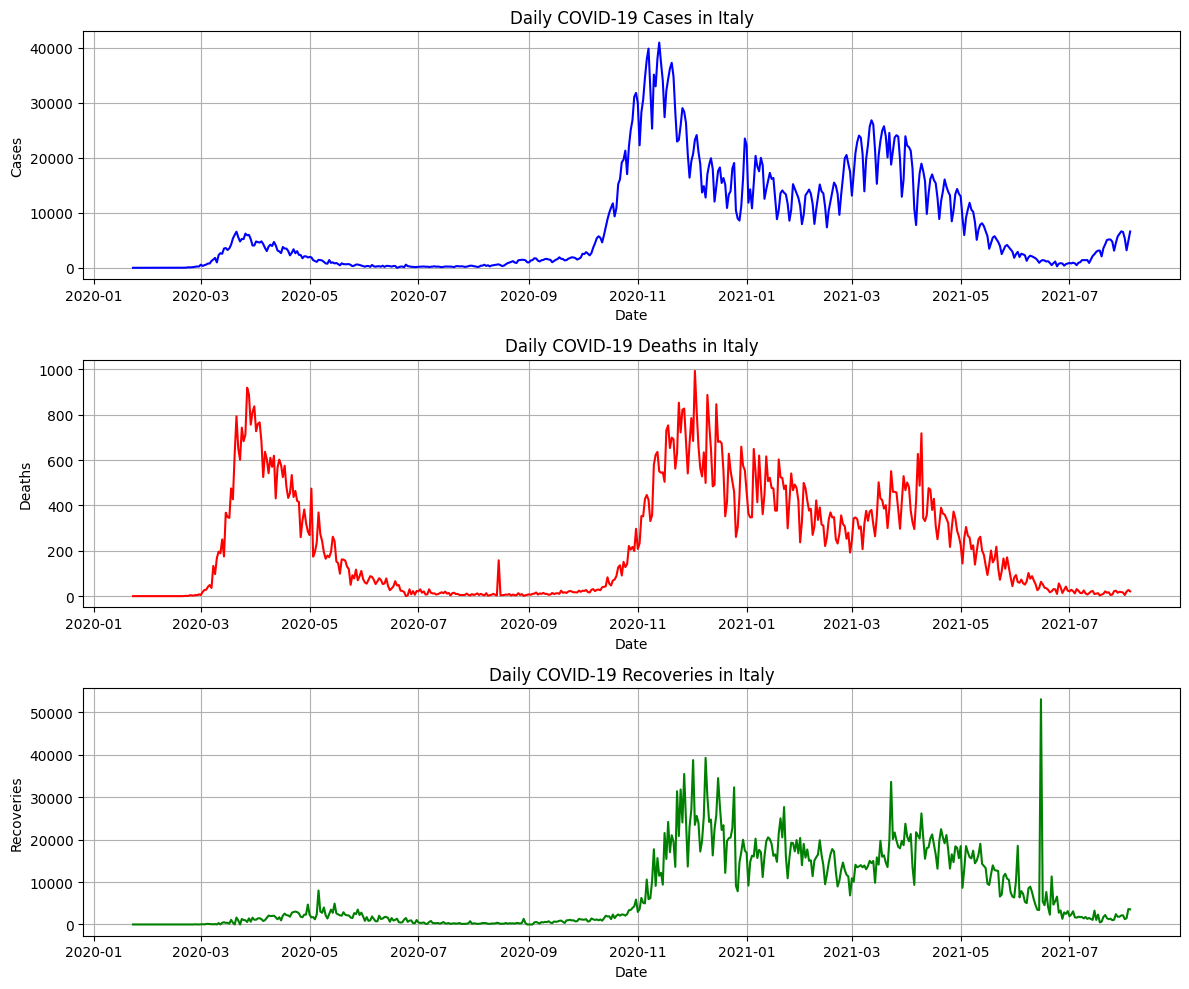

In [25]:
# Create a figure with three subplots
fig, axes = plt.subplots(3, 1, figsize = (12, 10))

# Plot Daily Cases
sns.lineplot(ax = axes[0], data = df_italy_1_daily, x = df_italy_1_daily.index, y = df_italy_1_daily["cases"], color = 'blue')
axes[0].set_title("Daily COVID-19 Cases in Italy")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Cases")
axes[0].grid(True)

# Plot Daily Deaths
sns.lineplot(ax = axes[1], data = df_italy_1_daily, x = df_italy_1_daily.index, y = df_italy_1_daily["deaths"], color = 'red')
axes[1].set_title("Daily COVID-19 Deaths in Italy")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Deaths")
axes[1].grid(True)

# Plot Daily Recoveries
sns.lineplot(ax = axes[2], data = df_italy_1_daily, x = df_italy_1_daily.index, y = df_italy_1_daily["recovered"], color = 'green')
axes[2].set_title("Daily COVID-19 Recoveries in Italy")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Recoveries")
axes[2].grid(True)

plt.tight_layout()
plt.show()


The line plots above show the daily trends for COVID-19 metrics in Italy from 22-01-2020  to 04-08-2021. This period covers the first three pandemic waves, characterized by increased infections, hospitalizations, and deaths. Specifically:

- *First Wave* (March 2020 – May 2020): The daily case count peaked at approximately $7,000$ cases, with a maximum of around $900$ daily deaths and $8,000$ daily recoveries. While the impact of the virus was severe, the total number of reported infections remained relatively low compared to later waves. This was likely due to more limited testing capabilities and the strict lockdown measures implemented early on.

- *Second Wave* (October 2020 – January 2021): This wave was significantly larger in scale. Daily cases surged to nearly eight times those of the first wave, reaching peaks of over $40,000$ cases per day. Despite the dramatic increase in infections, the number of daily deaths remained comparable to the first wave, suggesting improvements in medical treatments and increased hospital capacity. Recoveries also increased substantially, peaking at around $40,000$ per day, reflecting both the higher number of infections and possibly more efficient treatment protocols.

- *Third Wave* (March 2021 – May 2021): The peaks observed in this wave were slightly lower than those of the second wave, likely due to the effects of vaccination campaigns and the emergence of less severe variants.

Notably, the ratio of deaths to cases was significantly higher during the first wave compared to the subsequent waves. This can be attributed to factors such as improved testing, healthcare adaptation, the implementation of restrictions, and changes in public behavior.

Let us now analyse the DataFrame containing only the variables `cases` and `deaths` for the whole time period (`df_italy_2_daily`). This will allow us to gain a more comprehensive understanding of the long-term progression of these two metrics and will help us see how the situation evolved beyond July 2021.

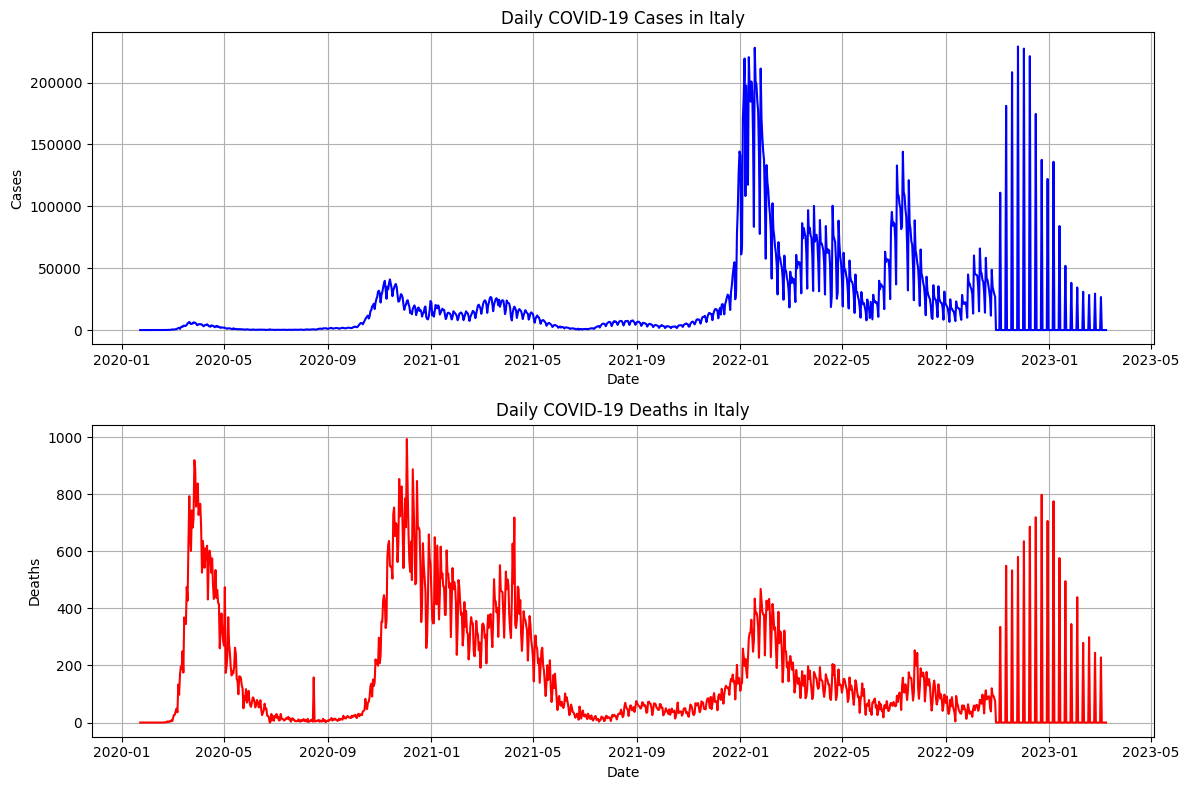

In [ ]:
# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize = (12, 8))

# Plot Daily Cases
sns.lineplot(ax = axes[0], data = df_italy_2_daily, x = df_italy_2_daily.index, y = df_italy_2_daily["cases"], color = 'blue')
axes[0].set_title("Daily COVID-19 Cases in Italy")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Cases")
axes[0].grid(True)

# Plot Daily Deaths
sns.lineplot(ax = axes[1], data = df_italy_2_daily, x = df_italy_2_daily.index, y = df_italy_2_daily["deaths"], color = 'red')
axes[1].set_title("Daily COVID-19 Deaths in Italy")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Deaths")
axes[1].grid(True)

plt.tight_layout()
plt.show()

The line plots above cover the entire period from January 2020 to March 2023. We can observe that:

- Additional waves occurred after 04-08-2021, with daily cases rising significantly compared to the first three waves. A peak of approximately $220,000$ daily cases was recorded after January 2022, far exceeding previous numbers. However, despite this sharp increase in infections, the number of daily deaths remained lower than in the previous waves. This trend suggests several possible factors at play, including widespread vaccination, improved medical treatments, and possible changes in the virus’s characteristics, making later variants more transmissible but less lethal.

- The number of cases tends to decline during the summer months. This could be attributed to several factors, including increased outdoor activities, school and workplace closures, and higher temperatures, which may influence virus transmission.

Additionally, a strange pattern appears in the later period, where both variables repeatedly drop to zero. To investigate this anomaly, we print the last three weeks of data.

In [27]:
df_italy_2_daily.tail(21)

,cases,deaths
2023-02-17,28347.0,299.0
2023-02-18,0.0,0.0
2023-02-19,0.0,0.0
2023-02-20,0.0,0.0
2023-02-21,0.0,0.0
2023-02-22,0.0,0.0
2023-02-23,0.0,0.0
2023-02-24,29438.0,244.0
2023-02-25,0.0,0.0
2023-02-26,0.0,0.0


As we can see, this irregular pattern is due to the data being updated only once a week. It can be observed that this change occurs approximately from the end of October 2022.

We now aggregate the data on a weekly basis to smooth out the daily fluctuations and highlight long-term trends. For this purpose, we create two new DataFrames:

- `df_italy_weekly_1`: Aggregating data from `df_italy_1_daily`, which includes cases, deaths, and recoveries up to August 2021.

- `df_italy_weekly_2`: Aggregating data from `df_italy_2_daily`, which contains cases and deaths up to March 2023.

In [28]:
# Perform weekly aggregation by summing the daily values within each week
df_italy_weekly_1 = df_italy_1_daily.resample('W').sum()
df_italy_weekly_2 = df_italy_2_daily.resample('W').sum()

We plot the weekly trends for both datasets below.

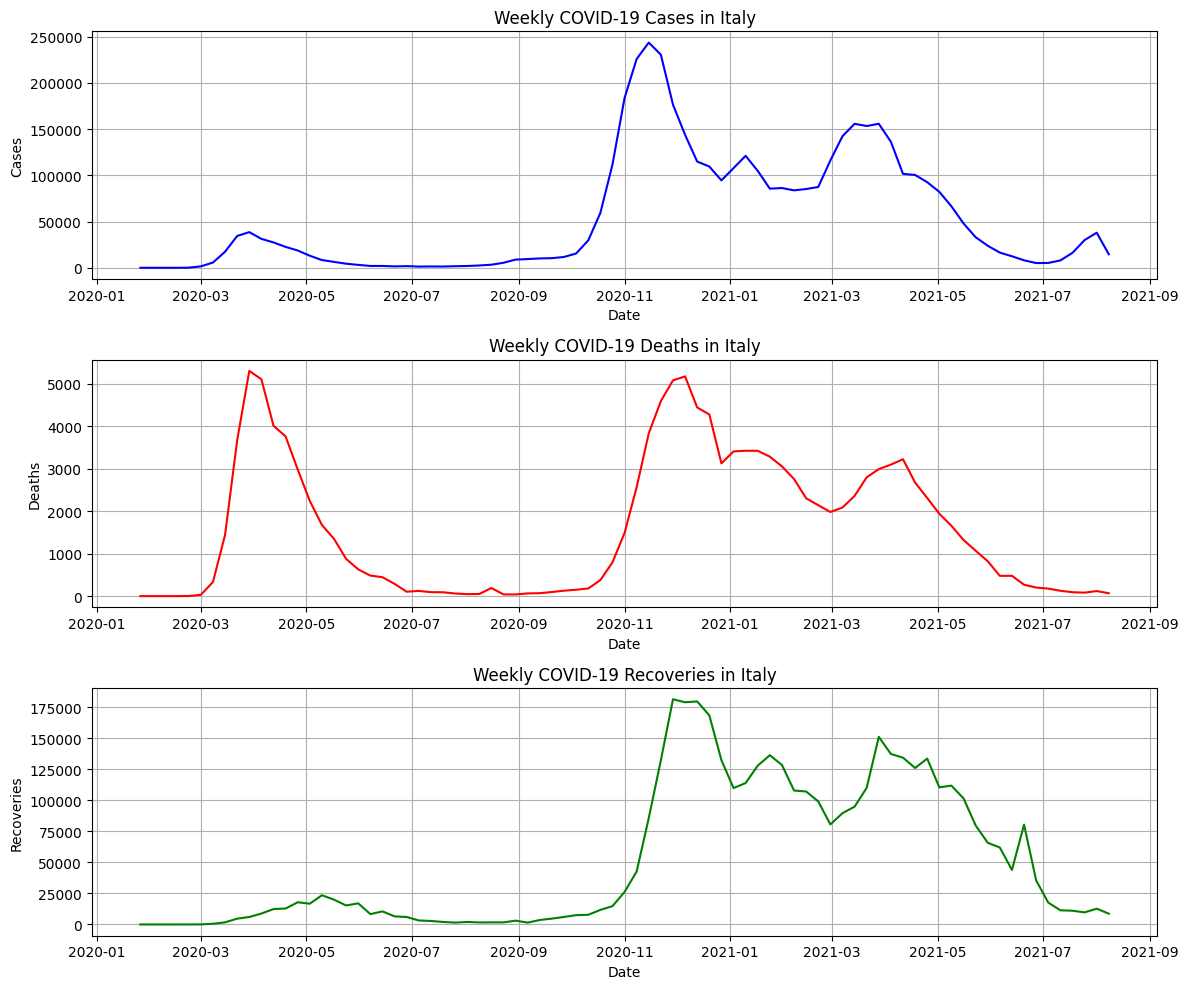

In [29]:
# Create a figure with three subplots 
fig, axes = plt.subplots(3, 1, figsize = (12, 10))

# Plot Weekly Cases
sns.lineplot(ax = axes[0], data = df_italy_weekly_1, x = df_italy_weekly_1.index, y = df_italy_weekly_1["cases"], color = 'blue')
axes[0].set_title("Weekly COVID-19 Cases in Italy")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Cases")
axes[0].grid(True)

# Plot Weekly Deaths
sns.lineplot(ax = axes[1], data = df_italy_weekly_1, x = df_italy_weekly_1.index, y = df_italy_weekly_1["deaths"], color = 'red')
axes[1].set_title("Weekly COVID-19 Deaths in Italy")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Deaths")
axes[1].grid(True)

# Plot Weekly Recoveries
sns.lineplot(ax = axes[2], data = df_italy_weekly_1, x = df_italy_weekly_1.index, y = df_italy_weekly_1["recovered"], color = 'green')
axes[2].set_title("Weekly COVID-19 Recoveries in Italy")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Recoveries")
axes[2].grid(True)

plt.tight_layout()
plt.show()


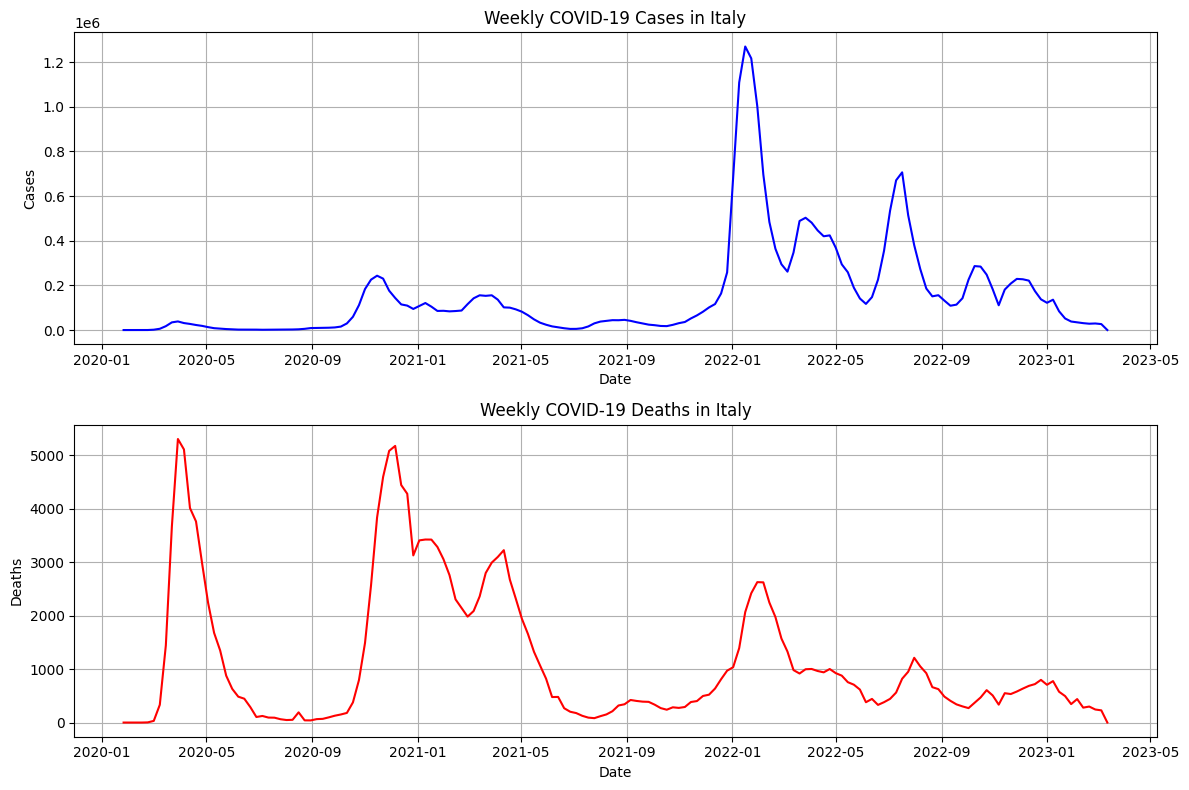

In [30]:
# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize = (12, 8))

# Plot Weekly Cases
sns.lineplot(ax = axes[0], data = df_italy_weekly_2, x = df_italy_weekly_2.index, y = df_italy_weekly_2["cases"], color = 'blue')
axes[0].set_title("Weekly COVID-19 Cases in Italy")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Cases")
axes[0].grid(True)

# Plot Weekly Deaths
sns.lineplot(ax = axes[1], data = df_italy_weekly_2, x = df_italy_weekly_2.index, y = df_italy_weekly_2["deaths"], color = 'red')
axes[1].set_title("Weekly COVID-19 Deaths in Italy")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Deaths")
axes[1].grid(True)

plt.tight_layout()
plt.show()

We can observe that the overall trends remain consistent with those seen in the daily plots. In particular:

- There are higher mortality rates from January 2020 to August 2021. During this period, the ratio of deaths to cases was significantly higher, especially in the early waves of the pandemic. As mentioned earlier, this is likely due to limited testing, overwhelmed healthcare systems, and the absence of vaccines in the initial phase.

- After August 2021 there is a substantial increase in infections, yet the number of deaths does not rise proportionally. This is probably due to vaccination, improved treatments, and the emergence of potentially less lethal variants of the virus.

- The number of reported cases consistently declines during the summer months, probably due to increased outdoor activities and to seasonal variations in the transmission of the virus.

These observations highlight the essential role of medical advancements and behavioral adaptations in shaping the progression of the pandemic over time.

## France

We repeat the exact same procedure for France.


We begin by analyzing the DataFrame that includes all variables up to 04-08-2021. We examine first the daily trends of the three variables, which are stored in the DataFrame `df_france_1_daily`. As before, we plot each variable separately using Seaborn.

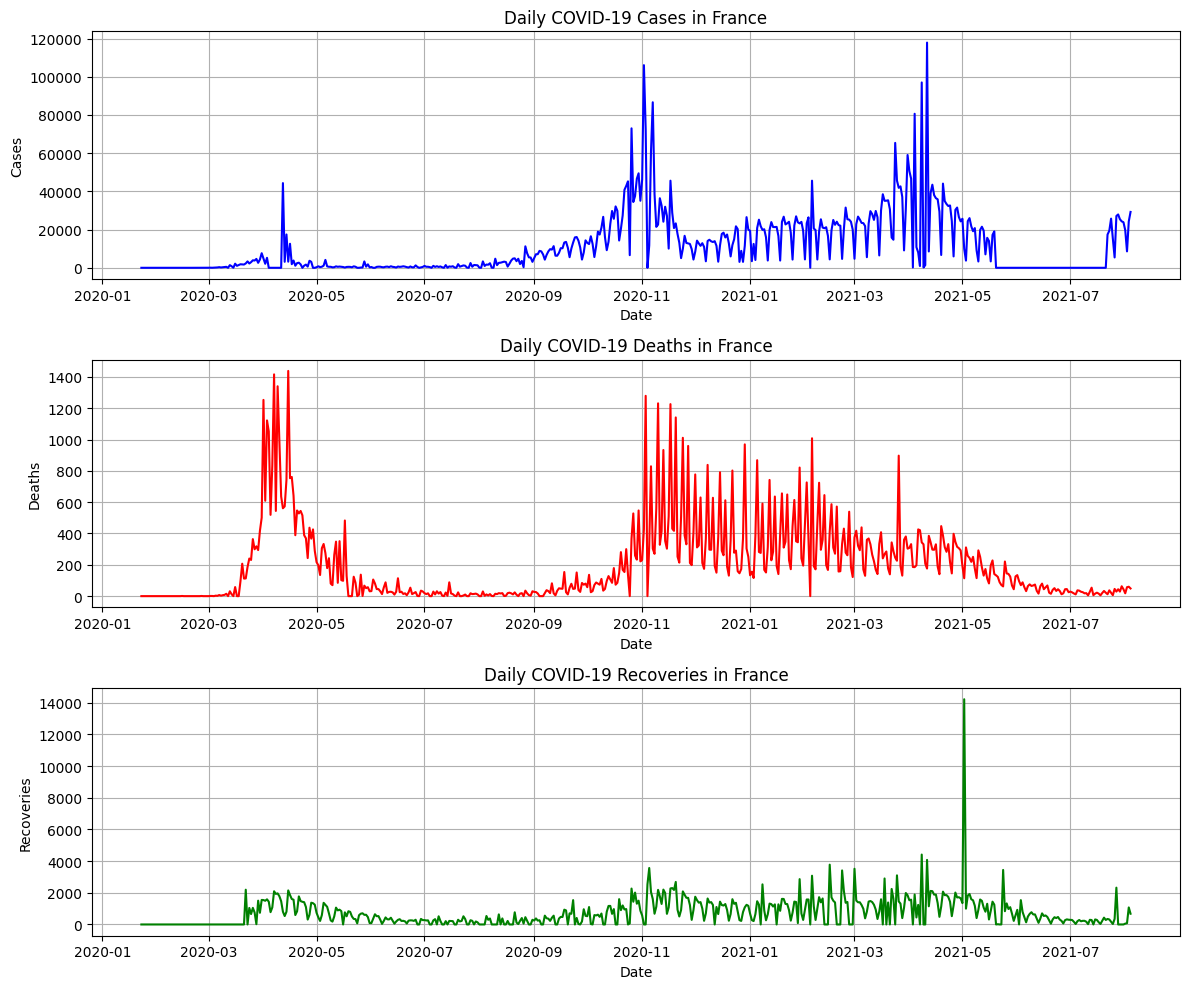

In [31]:
# Create a figure with three subplots 
fig, axes = plt.subplots(3, 1, figsize = (12, 10))

# Plot Daily Cases
sns.lineplot(ax = axes[0], data = df_france_1_daily, x = df_france_1_daily.index, y = df_france_1_daily["cases"], color = 'blue')
axes[0].set_title("Daily COVID-19 Cases in France")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Cases")
axes[0].grid(True)

# Plot Daily Deaths
sns.lineplot(ax = axes[1], data = df_france_1_daily, x = df_france_1_daily.index, y = df_france_1_daily["deaths"], color = 'red')
axes[1].set_title("Daily COVID-19 Deaths in France")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Deaths")
axes[1].grid(True)

# Plot Daily Recoveries
sns.lineplot(ax = axes[2], data = df_france_1_daily, x = df_france_1_daily.index, y = df_france_1_daily["recovered"], color = 'green')
axes[2].set_title("Daily COVID-19 Recoveries in France")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Recoveries")
axes[2].grid(True)

plt.tight_layout()
plt.show()

We can observe that:

- The above plots are challenging to interpret due to the high level of fluctuation. However, even in this case — particularly for the variables `cases` and `deaths` — we can distinguish three main pandemic waves, each marked by an increased number of infections and deaths. These roughly correspond to the periods March 2020 – May 2020, October 2020 – December 2020, and March 2021 – May 2021.

- As for the variable `recovered`, there is a value in May 2021 that is significantly higher than all other values. This is likely an outlier, but its extreme magnitude skews the scale of the graph, making it difficult to analyse the overall trend properly.

- As observed for Italy, the ratio of deaths to cases was significantly higher during the first wave compared to the subsequent ones. This is likely due to improved testing, medical advancements, the implementation of restrictions, and changes in public behavior. Indeed, the early phase of the pandemic was characterized by limited knowledge of the virus, overwhelmed healthcare systems, and fewer available treatments, all contributing to a higher mortality rate.

Let us now analyse the DataFrame containing only the variables `cases` and `deaths` for the whole time period (`df_france_2_daily`).

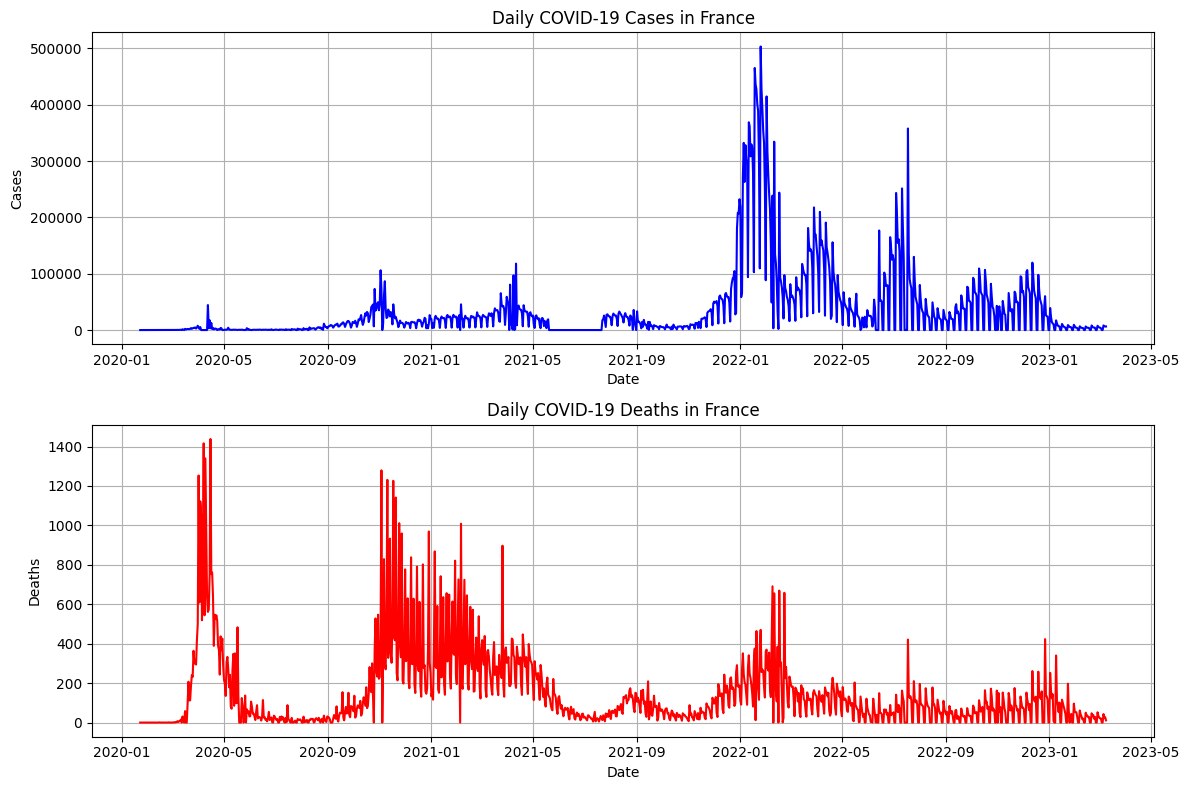

In [32]:
# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize = (12, 8))

# Plot Daily Cases
sns.lineplot(ax = axes[0], data = df_france_2_daily, x = df_france_2_daily.index, y = df_france_2_daily["cases"], color = 'blue')
axes[0].set_title("Daily COVID-19 Cases in France")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Cases")
axes[0].grid(True)

# Plot Daily Deaths
sns.lineplot(ax = axes[1], data = df_france_2_daily, x = df_france_2_daily.index, y = df_france_2_daily["deaths"], color = 'red')
axes[1].set_title("Daily COVID-19 Deaths in France")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Deaths")
axes[1].grid(True)

plt.tight_layout()
plt.show()

The line plots above cover the entire period from January 2020 to March 2023. As with the previous plots, these are also challenging to interpret due to the high level of fluctuation. Nevertheless, it is clear that additional waves occurred after 04-08-2021, with daily cases rising sharply compared to the first half of the graph. Moreover, as observed for Italy, despite this surge in infections, the number of daily deaths remained lower than in previous waves, likely due to vaccination, improved treatments, and changes in the virus's characteristics. 

Additionally, we note the following:

- There is a period between June 2021 and August 2021 where the number of daily cases is consistently zero. This is a consequence of how we initially handled the issue of negative values in the `df_france_daily` DataFrame. Specifically, we recall that a negative value appeared on 20-05-2021, and the error propagated forward. While having a continuous line of zeros is not ideal, it does not significantly impact the overall trend of the variable over the entire time period, so we can disregard it. To obtain a smoother trend, one could consider applying a linear interpolation between the values at the beginning and end of this period.

- Once again, we observe an unusual pattern in the final part of both plots, where both variables repeatedly drop to zero. To investigate this anomaly further, we print the last three weeks of data.

In [33]:
df_france_2_daily.tail(21)

,cases,deaths
2023-02-17,3589.0,28.0
2023-02-18,0.0,0.0
2023-02-19,0.0,0.0
2023-02-20,8133.0,47.0
2023-02-21,5774.0,32.0
2023-02-22,4602.0,38.0
2023-02-23,4489.0,19.0
2023-02-24,3917.0,29.0
2023-02-25,0.0,0.0
2023-02-26,0.0,0.0


As we can notice, this irregular pattern is due to the data not being updated during weekends.

As before, we now aggregate the data on a weekly basis to smooth out the daily fluctuations and highlight long-term trends. We create the following new DataFrames:

- `df_france_weekly_1`: Aggregating data from `df_france_1_daily`, which includes cases, deaths, and recoveries up to August 2021.

- `df_france_weekly_2`: Aggregating data from `df_france_2_daily`, which contains cases and deaths up to March 2023.

In [34]:
# Perform weekly aggregation by summing the daily values within each week
df_france_weekly_1 = df_france_1_daily.resample('W').sum()
df_france_weekly_2 = df_france_2_daily.resample('W').sum()

Below are the line plots showing the weekly trends for both datasets.

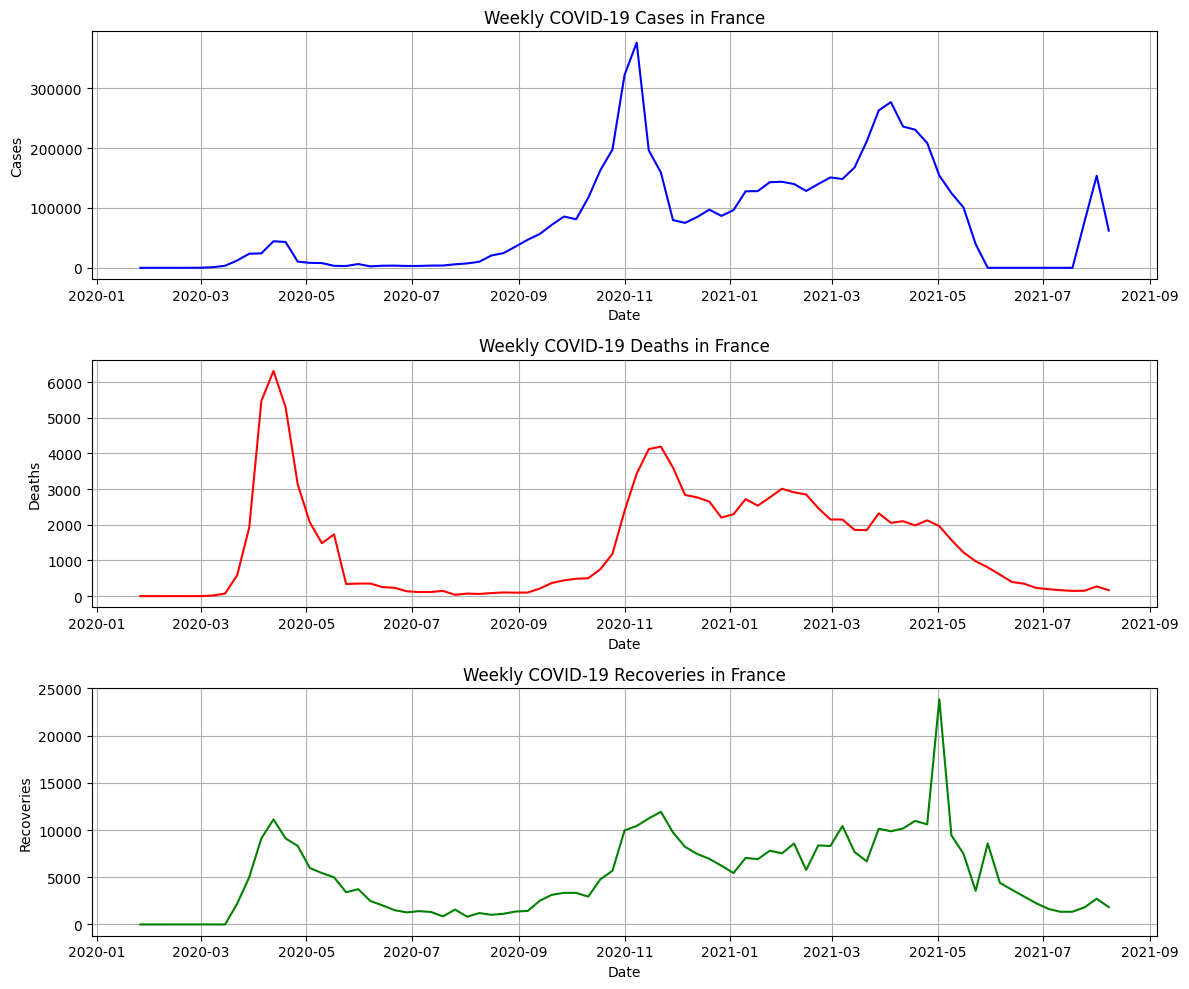

In [35]:
# Create a figure with three subplots 
fig, axes = plt.subplots(3, 1, figsize = (12, 10))

# Plot Weekly Cases
sns.lineplot(ax = axes[0], data = df_france_weekly_1, x = df_france_weekly_1.index, y = df_france_weekly_1["cases"], color = 'blue')
axes[0].set_title("Weekly COVID-19 Cases in France")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Cases")
axes[0].grid(True)

# Plot Weekly Deaths
sns.lineplot(ax = axes[1], data = df_france_weekly_1, x = df_france_weekly_1.index, y = df_france_weekly_1["deaths"], color = 'red')
axes[1].set_title("Weekly COVID-19 Deaths in France")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Deaths")
axes[1].grid(True)

# Plot Weekly Recoveries
sns.lineplot(ax = axes[2], data = df_france_weekly_1, x = df_france_weekly_1.index, y = df_france_weekly_1["recovered"], color = 'green')
axes[2].set_title("Weekly COVID-19 Recoveries in France")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Recoveries")
axes[2].grid(True)

plt.tight_layout()
plt.show()

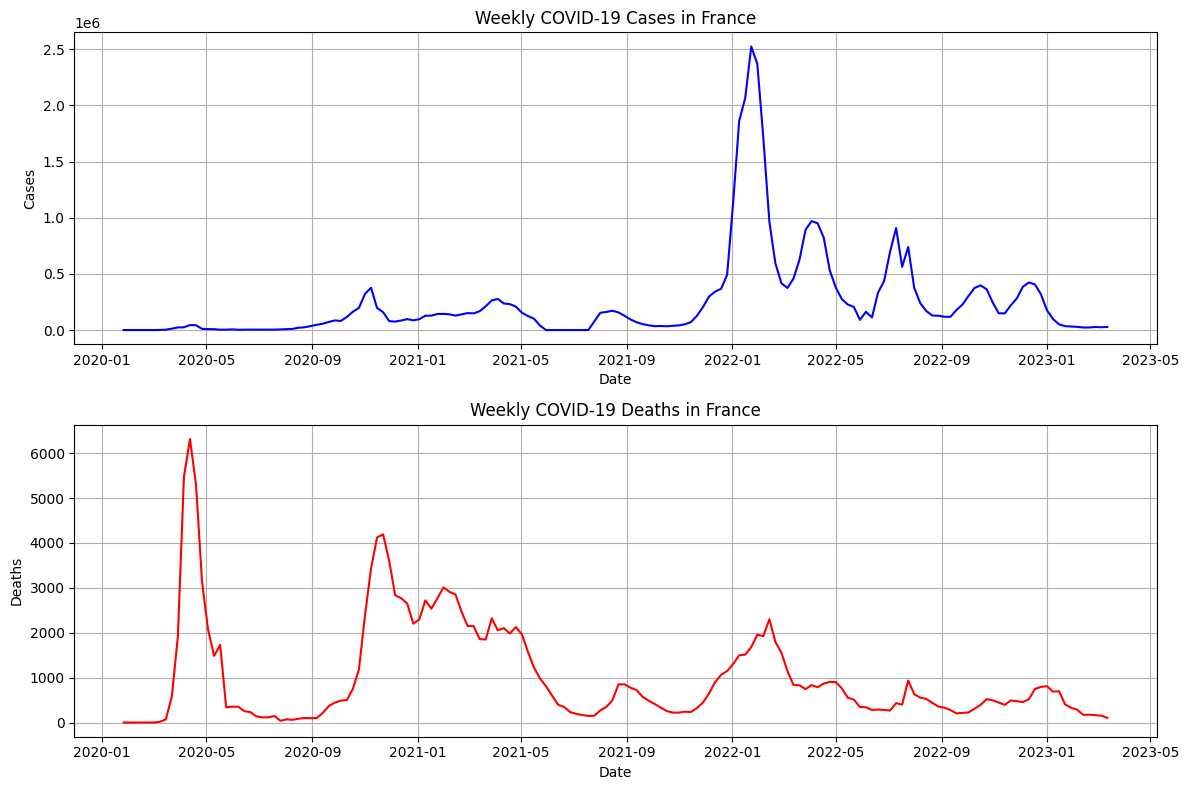

In [36]:
# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize = (12, 8))

# Plot Weekly Cases
sns.lineplot(ax = axes[0], data = df_france_weekly_2, x = df_france_weekly_2.index, y = df_france_weekly_2["cases"], color = 'blue')
axes[0].set_title("Weekly COVID-19 Cases in France")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Cases")
axes[0].grid(True)

# Plot Weekly Deaths
sns.lineplot(ax = axes[1], data = df_france_weekly_2, x = df_france_weekly_2.index, y = df_france_weekly_2["deaths"], color = 'red')
axes[1].set_title("Weekly COVID-19 Deaths in France")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Deaths")
axes[1].grid(True)

plt.tight_layout()
plt.show()

We can observe that aggregating the data on a weekly basis makes the trends much easier to visualize compared to the daily plots. The overall patterns remain consistent with those seen in the daily data, they are simply clearer and more interpretable. In particular, we can now identify with more clarity the three waves from January 2020 to August 2021, as well as the subsequent ones. Notably, the plot for the variable `recovered` is significantly more readable, as weekly aggregation reduces the skewness caused by the May 2021 outlier, allowing us to better distinguish the three waves observed in the daily plots.

# Comparative visualizations

To compare the progression of COVID-19 metrics in Italy and France, we use weekly trends, as they are smoother and easier to visualize and compare than daily trends.

We begin by analysing the DataFrames containing the weekly trends of all variables up to 04-08-2021 (`df_italy_weekly_1`, `df_france_weekly_1`). For each variable, we utilize both line plots for precise trend comparisons and area plots to highlight the overall magnitude.

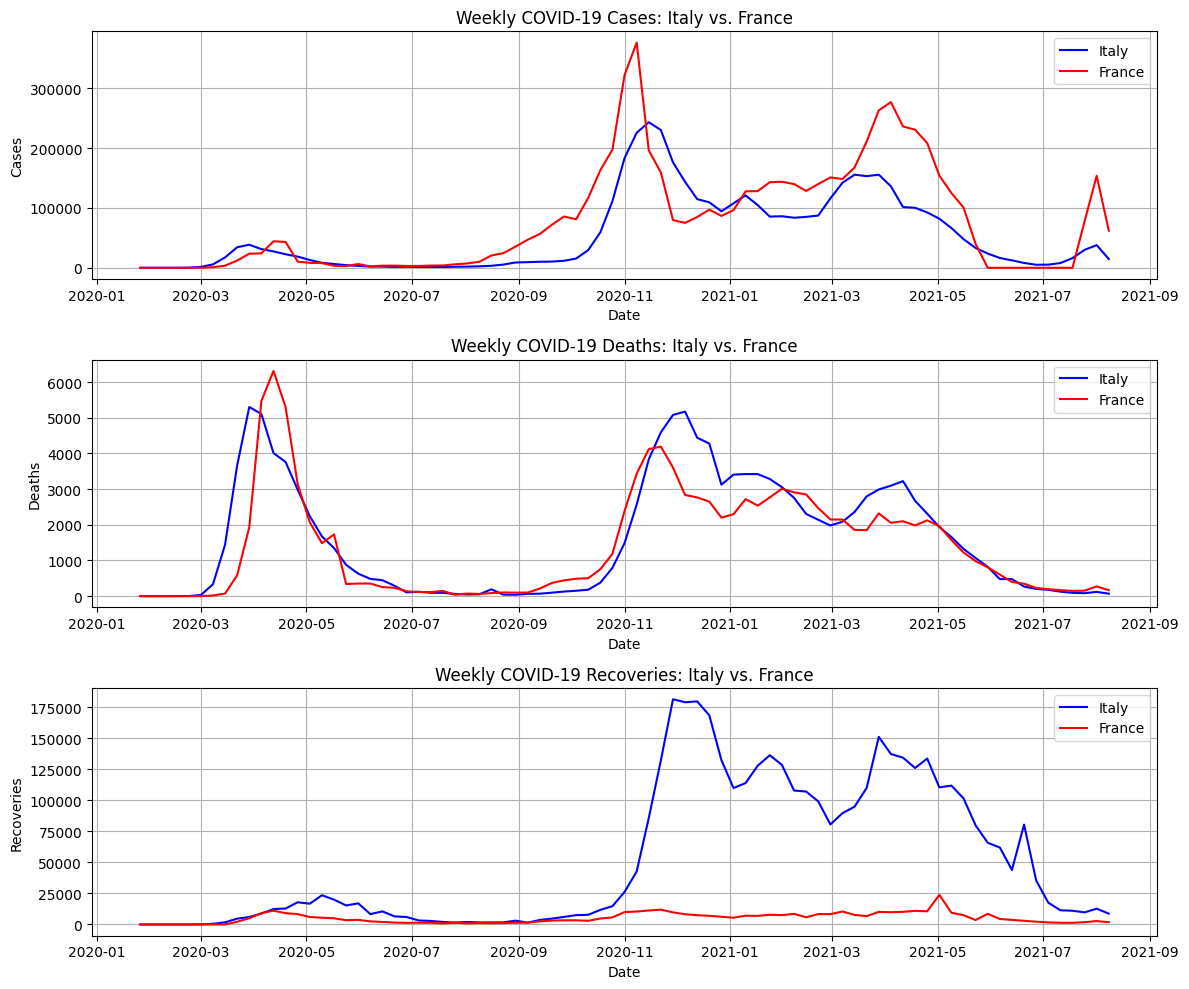

In [37]:
# Create a figure with three subplots
fig, axes = plt.subplots(3, 1, figsize = (12, 10))

# Define colors
colors = {"Italy": "blue", "France": "red"}

# Plot Weekly Cases (Line Plot)
sns.lineplot(ax = axes[0], x = df_italy_weekly_1.index, y = df_italy_weekly_1["cases"], color = colors["Italy"], label = "Italy")
sns.lineplot(ax = axes[0], x = df_france_weekly_1.index, y = df_france_weekly_1["cases"], color = colors["France"], label = "France")
axes[0].set_title("Weekly COVID-19 Cases: Italy vs. France")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Cases")
axes[0].legend()
axes[0].grid(True)

# Plot Weekly Deaths (Line Plot)
sns.lineplot(ax = axes[1], x = df_italy_weekly_1.index, y = df_italy_weekly_1["deaths"], color = colors["Italy"], label = "Italy")
sns.lineplot(ax = axes[1], x = df_france_weekly_1.index, y = df_france_weekly_1["deaths"], color = colors["France"], label = "France")
axes[1].set_title("Weekly COVID-19 Deaths: Italy vs. France")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Deaths")
axes[1].legend()
axes[1].grid(True)

# Plot Weekly Recoveries (Line Plot)
sns.lineplot(ax = axes[2], x = df_italy_weekly_1.index, y = df_italy_weekly_1["recovered"], color = colors["Italy"], label = "Italy")
sns.lineplot(ax = axes[2], x = df_france_weekly_1.index, y = df_france_weekly_1["recovered"], color = colors["France"], label = "France")
axes[2].set_title("Weekly COVID-19 Recoveries: Italy vs. France")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Recoveries")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()


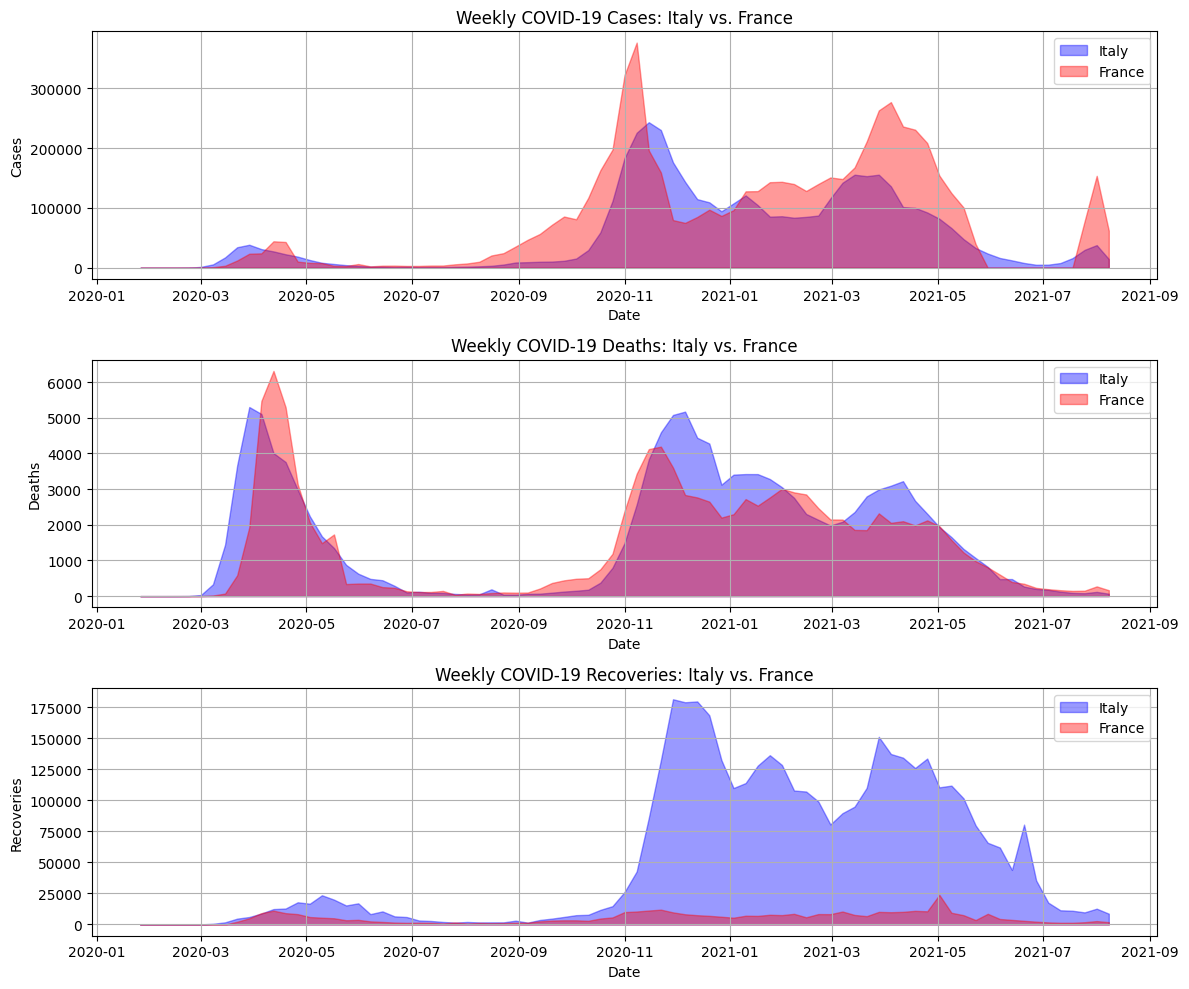

In [38]:
# Create a figure with three subplots 
fig, axes = plt.subplots(3, 1, figsize = (12, 10))

# Plot Weekly Cases (Area Plot)
axes[0].fill_between(df_italy_weekly_1.index, df_italy_weekly_1["cases"], color = colors["Italy"], alpha = 0.4, label = "Italy")
axes[0].fill_between(df_france_weekly_1.index, df_france_weekly_1["cases"], color = colors["France"], alpha = 0.4, label = "France")
axes[0].set_title("Weekly COVID-19 Cases: Italy vs. France")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Cases")
axes[0].legend()
axes[0].grid(True)

# Plot Weekly Deaths (Area Plot)
axes[1].fill_between(df_italy_weekly_1.index, df_italy_weekly_1["deaths"], color = colors["Italy"], alpha = 0.4, label = "Italy")
axes[1].fill_between(df_france_weekly_1.index, df_france_weekly_1["deaths"], color = colors["France"], alpha = 0.4, label = "France")
axes[1].set_title("Weekly COVID-19 Deaths: Italy vs. France")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Deaths")
axes[1].legend()
axes[1].grid(True)

# Plot Weekly Recoveries (Area Plot)
axes[2].fill_between(df_italy_weekly_1.index, df_italy_weekly_1["recovered"], color = colors["Italy"], alpha = 0.4, label = "Italy")
axes[2].fill_between(df_france_weekly_1.index, df_france_weekly_1["recovered"], color = colors["France"], alpha = 0.4, label = "France")
axes[2].set_title("Weekly COVID-19 Recoveries: Italy vs. France")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Recoveries")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

The above plots show that:

- For the variable `cases`, Italy and France exhibit similar trends. In general, the weekly number of cases in Italy appears to be lower, with France consistently reaching higher peaks than Italy, particularly during the periods October - November 2020 and April - May 2021.

- For the variable `deaths`, Italy and France again show similar trends. However, the number of deaths is often higher in Italy. While France reaches a higher peak in April 2020, in the second half of the plot, Italy's peaks tend to be higher.

- For the variable `recovered`, the trends are very similar up until November 2020. After that, while France's weekly recovery numbers remain stable, Italy experiences a significant increase, leading to very different trends and volumes in the second half of the plot.

Moreover, we can also notice that the weekly trends in the number of cases and deaths are very similar, which makes perfect sense since a higher number of cases generally leads to a higher number of deaths, with a certain delay.

We now analyse the DataFrames containing the weekly trends of only the variables `cases` and `deaths` for the entire time period (`df_italy_weekly_2`, `df_france_weekly_2`).

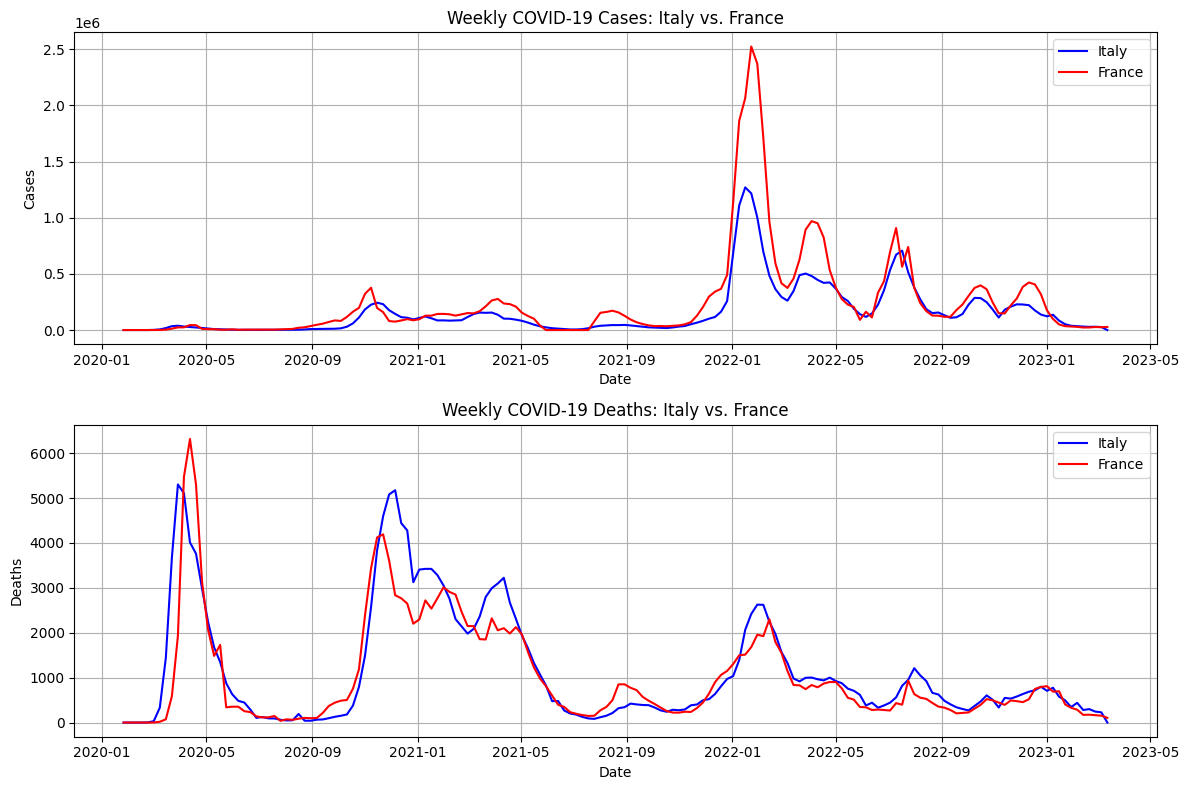

In [39]:
# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize = (12, 8))

# Plot Weekly Cases (Line Plot)
sns.lineplot(ax = axes[0], x = df_italy_weekly_2.index, y = df_italy_weekly_2["cases"], color = colors["Italy"], label = "Italy")
sns.lineplot(ax = axes[0], x = df_france_weekly_2.index, y = df_france_weekly_2["cases"], color = colors["France"], label = "France")
axes[0].set_title("Weekly COVID-19 Cases: Italy vs. France")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Cases")
axes[0].legend()
axes[0].grid(True)

# Plot Weekly Deaths (Line Plot)
sns.lineplot(ax = axes[1], x = df_italy_weekly_2.index, y = df_italy_weekly_2["deaths"], color = colors["Italy"], label = "Italy")
sns.lineplot(ax = axes[1], x = df_france_weekly_2.index, y = df_france_weekly_2["deaths"], color = colors["France"], label = "France")
axes[1].set_title("Weekly COVID-19 Deaths: Italy vs. France")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Deaths")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

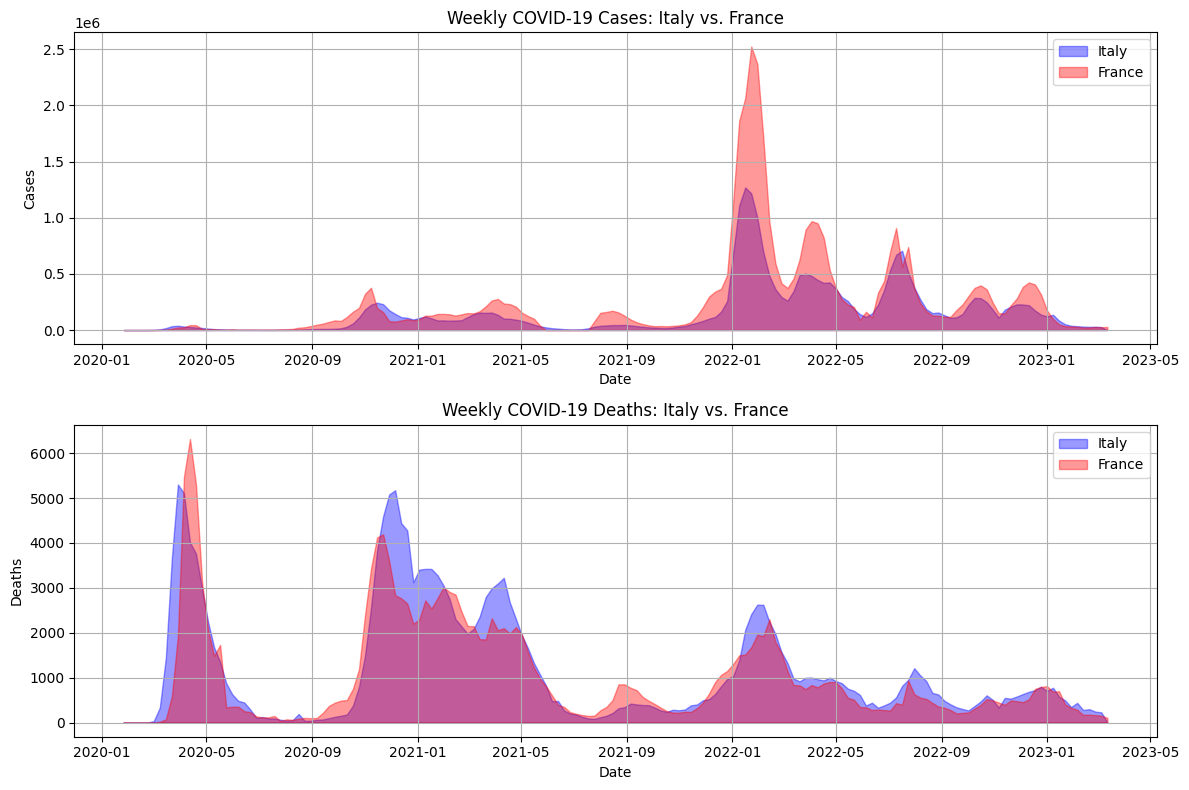

In [40]:
# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize = (12, 8))

# Plot Weekly Cases (Area Plot)
axes[0].fill_between(df_italy_weekly_2.index, df_italy_weekly_2["cases"], color = colors["Italy"], alpha = 0.4, label = "Italy")
axes[0].fill_between(df_france_weekly_2.index, df_france_weekly_2["cases"], color = colors["France"], alpha = 0.4, label = "France")
axes[0].set_title("Weekly COVID-19 Cases: Italy vs. France")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Cases")
axes[0].legend()
axes[0].grid(True)

# Plot Weekly Deaths (Area Plot)
axes[1].fill_between(df_italy_weekly_2.index, df_italy_weekly_2["deaths"], color = colors["Italy"], alpha = 0.4, label = "Italy")
axes[1].fill_between(df_france_weekly_2.index, df_france_weekly_2["deaths"], color = colors["France"], alpha = 0.4, label = "France")
axes[1].set_title("Weekly COVID-19 Deaths: Italy vs. France")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Deaths")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

As we can see from the above plots, the trends after 04-08-2021 remain similar in Italy and France for both variables. As before, the weekly number of cases in Italy is often lower than in France, with France consistently reaching higher peaks, particularly in January 2022 and April 2022. Similarly, the weekly number of deaths is generally higher in Italy; except for April 2020 and September 2021, where France experiences higher peaks, Italy's peaks tend to be slightly higher throughout the rest of the period.

# Conclusions

Our analysis of COVID-19 progression in Italy and France highlights several key similarities and differences in the trends of cases, deaths, and recoveries. Both countries experienced similar pandemic waves, but with some differences in magnitude:

- France consistently reported higher peaks in weekly cases compared to Italy, suggesting either higher transmission rates or differences in testing strategies between the two countries.

- While both countries exhibited similar mortality trends, Italy generally recorded higher peaks in deaths, except during April 2020 and September 2021, where France reached higher peaks. This could indicate differences in the healthcare system or can be due to demographic factors.

- Until November 2020, recovery trends were similar in both countries. However, after this point, Italy saw a substantial rise in reported recoveries, diverging from the relatively stable trend observed in France. This discrepancy may be due to differences in how recoveries were recorded or reported.

- In both countries, cases tended to decline during the summer months, likely due to behavioral changes, increased outdoor activities, and possible seasonal variations in the virus transmission. Additionally, after August 2021, despite a sharp rise in infections, the number of deaths remained lower than in previous waves, likely due to the impact of vaccination, improved treatments, and changes in the virus’s characteristics.

Overall, while Italy and France followed similar trajectories, variations in case numbers, mortality peaks, and recovery trends highlight country-specific differences in the pandemic response.